# Importing Libraries

In [ ]:
!pip install shap==0.43.0
import numpy as np
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 3.5 MB/s eta 0:00:00


Mount to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DSGA-1017 RDS Final Project/healthcare-dataset-stroke-data.csv")

In [ ]:
df.drop('id', axis=1, inplace=True)
df.shape

(5110, 11)

In [ ]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
len(df[df['stroke'] == 0]) / 5110

0.9512720156555773

# Exploratory Data Analysis


Repeat after SMOTE

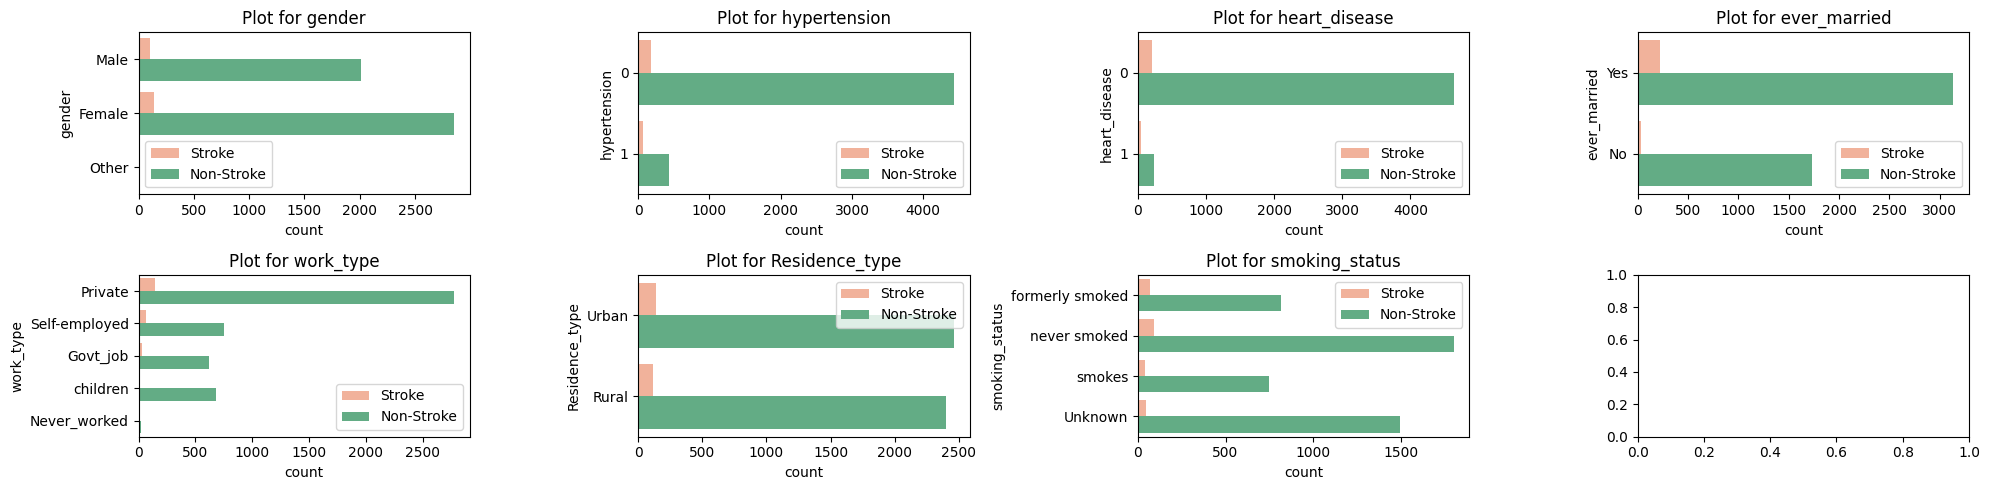

In [ ]:
data = df.copy()
data['stroke'] = data['stroke'].replace({0:'Non-Stroke', 1:'Stroke'})
color_palette = {'Stroke': '#ffab8d', 'Non-Stroke': '#57b884'}
cat_feats = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_feats = ['age', 'avg_glucose_level', 'bmi']
fig, axes = plt.subplots(2, 4, figsize=(20, 5))
axes = axes.flatten()
for i, cat_feat in enumerate(cat_feats):
  #sns.catplot(y=cat_feat, hue="stroke", kind="count", palette="husl", data=df, height=3, ax=axes[i])
  sns.countplot(y=cat_feat, hue="stroke", palette=color_palette, data=data, ax=axes[i])
  axes[i].legend(title='') #remove the title of 'stoke' to make the legend part clearer
  axes[i].set_title(f'Plot for {cat_feat}')

plt.tight_layout()
plt.show()

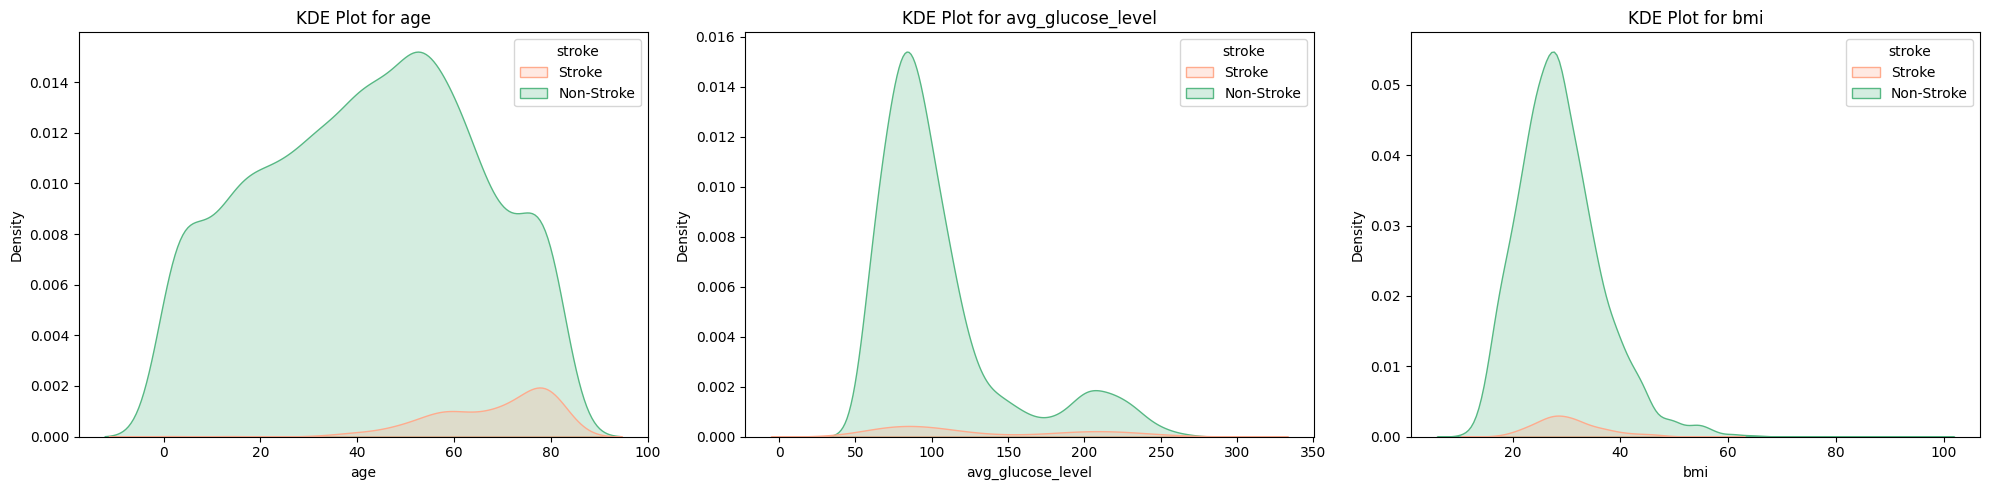

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
for i, num_feat in enumerate(num_feats):
  sns.kdeplot(x=num_feat, hue='stroke', palette=color_palette, data=data, multiple='layer', fill = True, ax=axes[i], legend = True)
  axes[i].set_title(f'KDE Plot for {num_feat}')
plt.tight_layout()
plt.show()


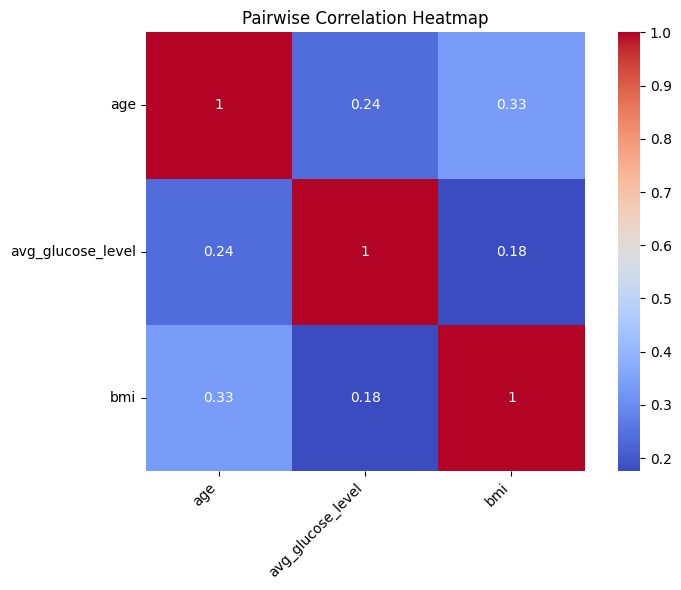

In [ ]:
corr_matrix = df[num_feats].corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, ax=ax)
ax.set_title('Pairwise Correlation Heatmap')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# Original Solution

In [ ]:
def pipeline(df, seed=666):
  df.dropna(inplace=True)
  X = df.drop('stroke', axis=1)
  y = df['stroke']
  numerical_cols = ['age', 'avg_glucose_level', 'bmi']
  categorical_cols = ['work_type', 'Residence_type']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)
  scaler = StandardScaler()
  X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
  X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first').fit(X_train[categorical_cols])
  encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
  X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
  X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])
  X_train.drop(['work_type', 'Residence_type'], axis=1, inplace=True)
  X_test.drop(['work_type', 'Residence_type'], axis=1, inplace=True)
  label_mappings = {
  'gender' : {'Male': 0, 'Female': 1, 'Other': 2},
  'ever_married' : {'Yes': 1, 'No': 0},
  'smoking_status' : {'smokes': 1, 'never smoked': 2, 'formerly smoked': 3, 'Unknown': 4}
  }
  for column, mapping in label_mappings.items():
    X_train[f'{column}'] = X_train[column].map(mapping)
    X_test[f'{column}'] = X_test[column].map(mapping)
  smote = SMOTE(random_state=666)
  X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
  best_rf_model = RandomForestClassifier(random_state=666, n_jobs=-1, max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150)
  best_rf_model.fit(X_balanced, y_balanced)
  y_pred = best_rf_model.predict(X_test)
  tuned_rf_accuracy = accuracy_score(y_test, y_pred)
  return best_rf_model, X_train, y_train, X_balanced, y_balanced, X_test, y_test, y_pred

# Auditting

### Visualize balanced data

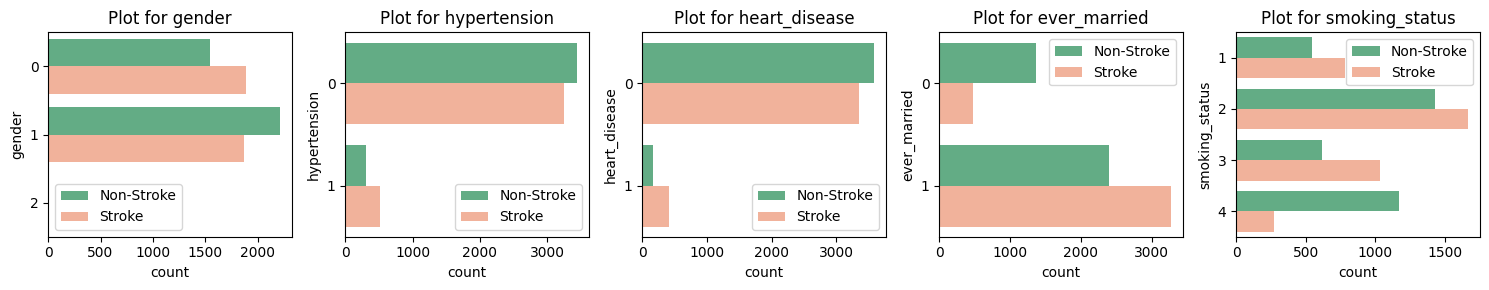

In [ ]:
best_model, X_train, y_train, X_balanced, y_balanced, X_test, y_test, y_pred = pipeline(df)
data = X_balanced.copy()
data['stroke'] = y_balanced.replace({0:'Non-Stroke', 1:'Stroke'})
color_palette = {'Stroke': '#ffab8d', 'Non-Stroke': '#57b884'}
cat_feats = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status']
num_feats = ['age', 'avg_glucose_level', 'bmi']
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
for i, cat_feat in enumerate(cat_feats):
  #sns.catplot(y=cat_feat, hue="stroke", kind="count", palette="husl", data=df, height=3, ax=axes[i])
  sns.countplot(y=cat_feat, hue="stroke", palette=color_palette, data=data, ax=axes[i])
  axes[i].legend(title='')
  axes[i].set_title(f'Plot for {cat_feat}')

plt.tight_layout()
plt.show()

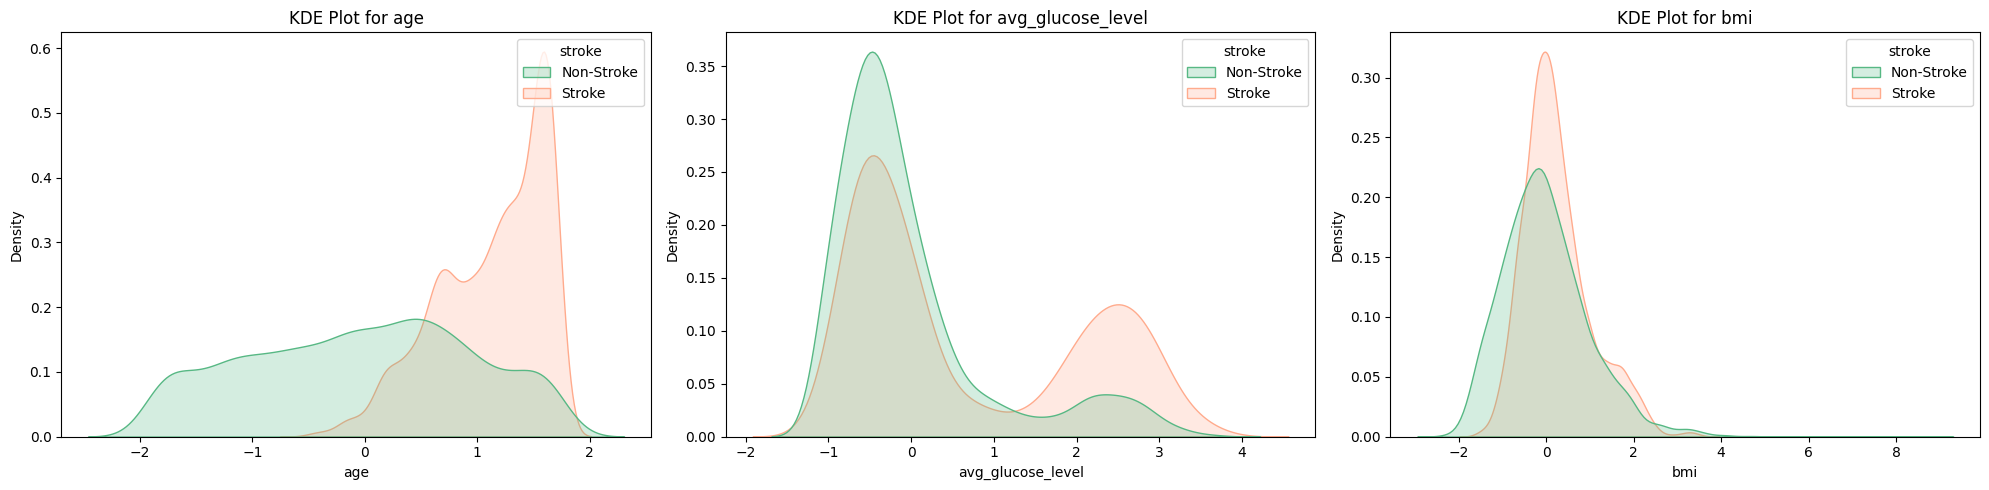

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
for i, num_feat in enumerate(num_feats):
  sns.kdeplot(x=num_feat, hue='stroke', palette=color_palette, data=data, multiple='layer', fill = True, ax=axes[i])
  axes[i].set_title(f'KDE Plot for {num_feat}')
plt.tight_layout()
plt.show()

### Validation on cross validation of balanced data (50:50). Good accuracy. Author deems it as a good model

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=666, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_balanced, y_balanced)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Accuracy: 0.9599547359182343


### Define Smote Inflation Factor := $\frac{\frac{proportion of stroke in male after smote}{proportion of stroke in female after smote}}{\frac{proportion of stroke in male before smote}{proportion of stroke in female before smote}}$
This computes how many times larger or smaller the dataset after SMOTE amplifies or shrinks the label disparity in each subgroup.
The base rate gap is amplified in the balanced samples

In [ ]:
def computeSIF(X_train, y_train, X_balanced, y_balanced):
  nume = (np.sum(y_balanced[X_balanced[X_balanced['gender'] == 0].index]) / len(X_balanced[X_balanced['gender'] == 0].index)) / (np.sum(y_balanced[X_balanced[X_balanced['gender'] == 1].index]) / len(X_balanced[X_balanced['gender'] == 1].index))
  deno = (np.sum(y_train[X_train[X_train['gender'] == 0].index]) / len(X_train[X_train['gender'] == 0].index)) / (np.sum(y_train[X_train[X_train['gender'] == 1].index]) / len(X_train[X_train['gender'] == 1].index))
  return nume / deno

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

SMOTE may have treated some class imbalance to get better acc, but it exacerbated bias

In [ ]:
!pip install fairlearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)
from fairlearn.metrics import MetricFrame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
def performance_fairness(results, X_test, y_test, y_pred, X_train, y_train, X_balanced, y_balanced):
  X_test['gender'] = X_test['gender'].replace(2, 1)
  sensFeats = X_test['gender'].replace({0:'Male', 1:'Female & Other'})
  metrics = {'accuracy': accuracy_score,
            'precision': precision_score,
            'recall': recall_score,
            'FNR': false_negative_rate,
            'FPR': false_positive_rate
              }
  met = MetricFrame(metrics = metrics,
                    y_true = y_test,
                    y_pred = y_pred,
                    sensitive_features = sensFeats)
  accuracy = met.overall['accuracy']
  precision = met.overall['precision']
  recall = met.overall['recall']
  FNR = met.overall['FNR']
  FPR = met.overall['FPR']

  accuracyFemale = met.by_group[met.by_group.index == 'Female & Other']['accuracy']
  precisionFemale = met.by_group[met.by_group.index == 'Female & Other']['precision']
  recallFemale = met.by_group[met.by_group.index == 'Female & Other']['recall']
  FNRFemale = met.by_group[met.by_group.index == 'Female & Other']['FNR']
  FPRFemale = met.by_group[met.by_group.index == 'Female & Other']['FPR']
  accuracyMale = met.by_group[met.by_group.index == 'Male']['accuracy']
  precisionMale = met.by_group[met.by_group.index == 'Male']['precision']
  recallMale = met.by_group[met.by_group.index == 'Male']['recall']
  FNRMale = met.by_group[met.by_group.index == 'Male']['FNR']
  FPRMale = met.by_group[met.by_group.index == 'Male']['FPR']

  FNRDiff = false_negative_rate_difference(y_test, y_pred, sensitive_features = sensFeats)
  FPRDiff = false_positive_rate_difference(y_test, y_pred, sensitive_features = sensFeats)
  demoParityRatio = demographic_parity_ratio(y_test, y_pred, sensitive_features = sensFeats)
  eqOddsRatio = equalized_odds_ratio(y_test, y_pred, sensitive_features = sensFeats)
  #selectionRateDiff = selection_rate_difference(y_test, y_pred, sensitive_features = sensFeats)
  SIF = computeSIF(X_train, y_train, X_balanced, y_balanced)

  results['accuracy'].append(accuracy)
  results['precision'].append(precision)
  results['recall'].append(recall)
  results['FNR'].append(FNR)
  results['FPR'].append(FPR)
  results['accuracyFemale'].append(accuracyFemale)
  results['precisionFemale'].append(precisionFemale)
  results['recallFemale'].append(recallFemale)
  results['FNRFemale'].append(FNRFemale)
  results['FPRFemale'].append(FPRFemale)
  results['accuracyMale'].append(accuracyMale)
  results['precisionMale'].append(precisionMale)
  results['recallMale'].append(recallMale)
  results['FNRMale'].append(FNRMale)
  results['FPRMale'].append(FPRMale)
  results['FNRDiff'].append(FNRDiff)
  results['FPRDiff'].append(FPRDiff)
  results['demoParityRatio'].append(demoParityRatio)
  results['eqOddsRatio'].append(eqOddsRatio)
  #results['selectionRateDiff'].append(selectionRateDiff)
  results['SIF'].append(SIF)

In [ ]:
results = {'accuracy': [], 'precision': [], 'recall': [], 'FNR': [], 'FPR': [],
        'accuracyFemale': [], 'precisionFemale': [], 'recallFemale': [], 'FNRFemale': [], 'FPRFemale': [],
        'accuracyMale': [], 'precisionMale': [], 'recallMale': [], 'FNRMale': [], 'FPRMale': [],
        'FNRDiff': [], 'FPRDiff': [], 'demoParityRatio': [], 'eqOddsRatio': [], 'SIF': []} #, 'selectionRateDiff': []}
seeds = [7, 17, 57, 127, 520, 73, 1122, 35, 90, 100]
for seed in seeds:
  model, X_train, y_train, X_balanced, y_balanced, X_test, y_test, y_pred = pipeline(df, seed=seed)
  performance_fairness(results, X_test, y_test, y_pred, X_train, y_train, X_balanced, y_balanced)

results['Acc M-F&O'] = np.array(results['accuracyMale']) - np.array(results['accuracyFemale'])
results['Prec M-F&O'] = np.array(results['precisionMale']) - np.array(results['precisionFemale'])
results['Recall M-F&O'] = np.array(results['recallMale']) - np.array(results['recallFemale'])
results['FNR M-F&O'] = np.array(results['FNRMale']) - np.array(results['FNRFemale'])
results['FPR M-F&O'] = np.array(results['FPRMale']) - np.array(results['FPRFemale'])

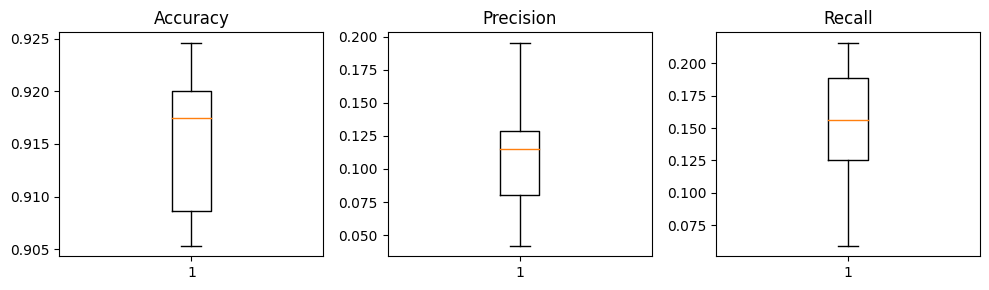

In [ ]:
perMetricsLst = ['accuracy', 'precision', 'recall'] #, 'accuracyFemale', 'precisionFemale', 'recallFemale']
titles = ['Accuracy', 'Precision', 'Recall']
fig, axs = plt.subplots(1, 3, figsize = (10, 3))
axs = axs.flatten()
for i in range(int(len(perMetricsLst))):
    axs[i].boxplot(np.array(results[perMetricsLst[i]]).flatten())
    #axs[i].set_ylim(bottom = 0)
    #axs[i].set_title(metricsLst[i])
    #axs[i].set_xticks([1, 2])
    axs[i].set_title(titles[i])
    #axs[i].set_xticklabels(fairMetricsLst[i])
    #axs[i].set_xlabel('RF Models')

plt.tight_layout()
plt.show()

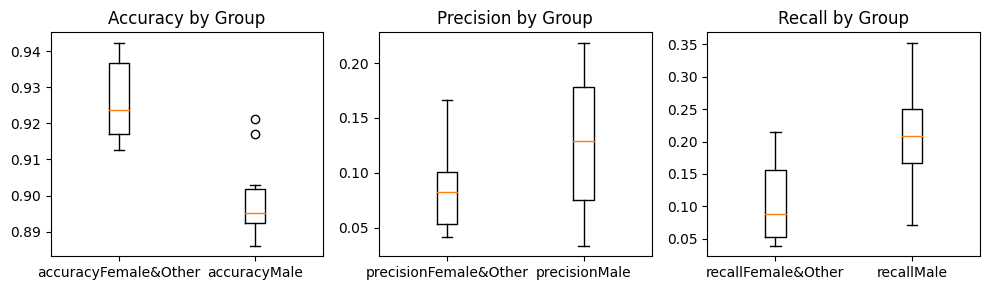

In [ ]:
# perMetricsBySexLst = ['accuracyFemale', 'precisionFemale', 'recallFemale', 'FNRFemale', 'FPRFemale',
#         'accuracyMale', 'precisionMale', 'recallMale', 'FNRMale', 'FPRMale']
perMetricsBySexLst = ['accuracyFemale', 'precisionFemale', 'recallFemale', 'accuracyMale', 'precisionMale', 'recallMale']
xLabels = ['accuracyFemale&Other', 'precisionFemale&Other', 'recallFemale&Other', 'accuracyMale', 'precisionMale', 'recallMale']
titles = ['Accuracy by Group', 'Precision by Group', 'Recall by Group'] #, 'FNR by Group', 'FPR by Group']


fig, axs = plt.subplots(1, 3, figsize = (10, 3))
axs = axs.flatten()
for i in range(int(len(perMetricsBySexLst) / 2)):
    axs[i].boxplot([np.array(results[perMetricsBySexLst[i]]).flatten(),
            np.array(results[perMetricsBySexLst[i + 3]]).flatten()],
            positions = [1, 2])
    #axs[i].set_ylim(bottom = 0)
    axs[i].set_title(titles[i])
    axs[i].set_xticks([1, 2])
    axs[i].set_xticklabels([xLabels[i], xLabels[i + 3]])
    #axs[i].set_xlabel('RF Models')

plt.tight_layout()
plt.show()

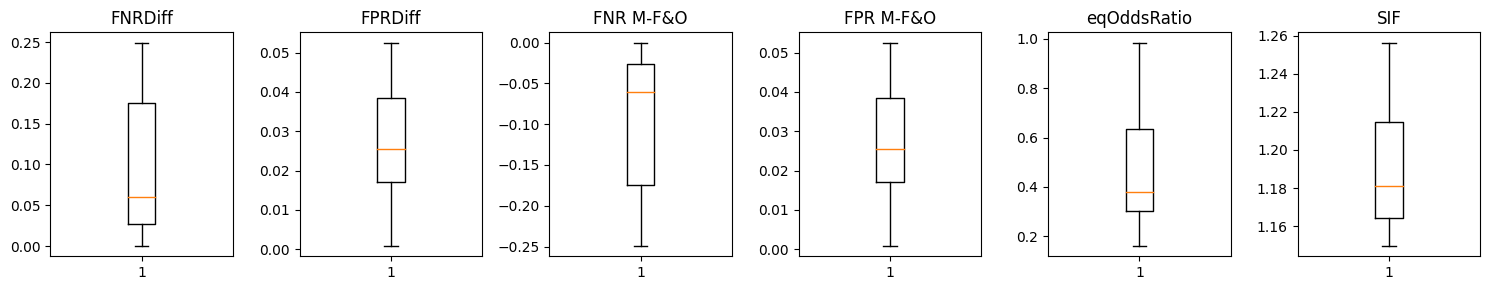

In [ ]:
#fairMetricsLst = ['Acc M-F&O', 'Prec M-F&O', 'Recall M-F&O', 'FNR M-F&O', 'FPR M-F&O', 'FNRDiff', 'FPRDiff', 'demoParityRatio', 'eqOddsRatio', 'SIF']
fairMetricsLst = ['FNRDiff', 'FPRDiff', 'FNR M-F&O', 'FPR M-F&O', 'eqOddsRatio', 'SIF']
fig, axs = plt.subplots(1, 6, figsize = (15, 3))
axs = axs.flatten()
for i in range(int(len(fairMetricsLst))):
    axs[i].boxplot(np.array(results[fairMetricsLst[i]]).flatten())
    #axs[i].set_ylim(bottom = 0)
    #axs[i].set_title(metricsLst[i])
    #axs[i].set_xticks([1, 2])
    axs[i].set_title(fairMetricsLst[i])
    #axs[i].set_xticklabels(fairMetricsLst[i])
    #axs[i].set_xlabel('RF Models')

plt.tight_layout()
plt.show()

# **SHAP and Transparency**

# **Feature Importance**


 99%|===================| 1947/1964 [02:10<00:01]       

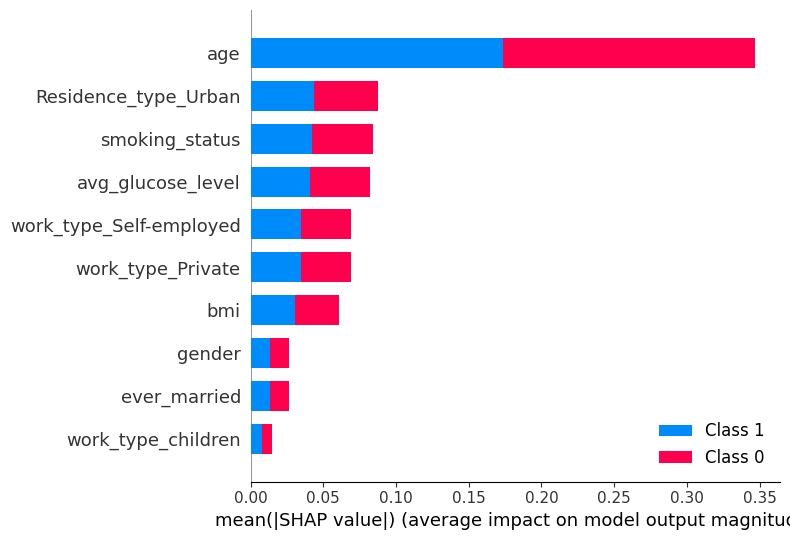

In [ ]:
explainer = shap.TreeExplainer(best_model, X_balanced)
shap_values = explainer.shap_values(X_test, check_additivity = False)
shap.summary_plot(shap_values, X_test, max_display = 10)

**summary_plot of the label “1”(stroke)**

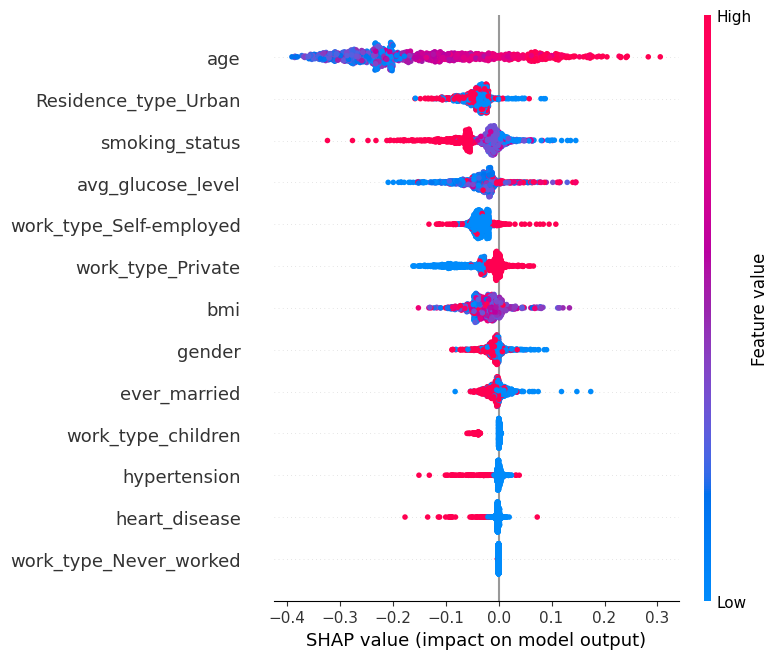

In [ ]:
shap.summary_plot(shap_values[1], X_test)

We can describe the model. A prediction of stroke is associated with the following characteristics:


*   older age
*   living in suburban
*   high average glucose level
*   private work type
*   smoking




# **Dependence Plots for Selected Features**

**How the model's predictions for 'stoke' are affected by 'age'**

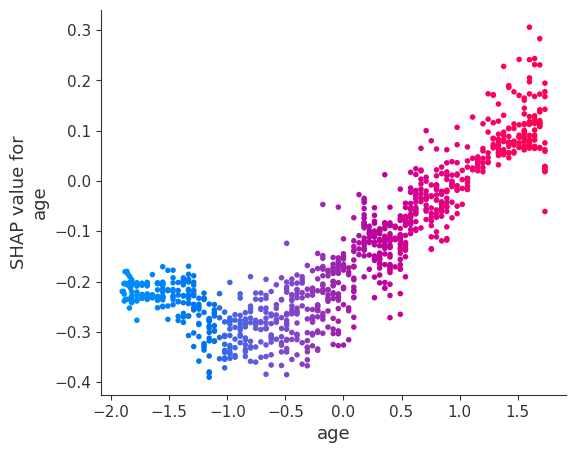

In [ ]:
shap.dependence_plot("age", shap_values[1], X_test,interaction_index="age")

The above plot shows there is an approximately linear and positive trend between “age” and the target variable

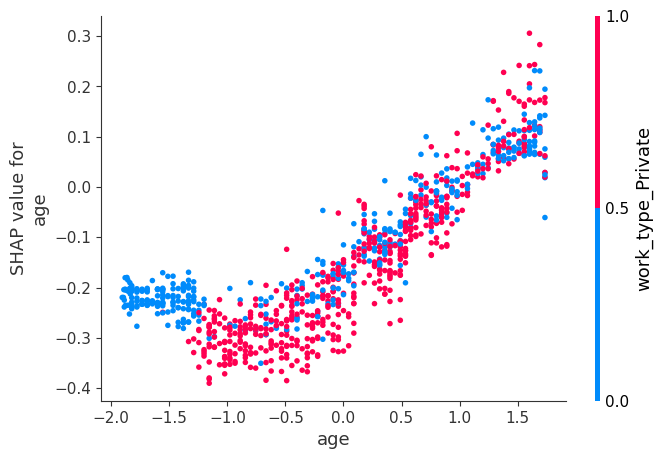

In [ ]:
shap.dependence_plot("age", shap_values[1], X_test)

This indicates that “age” interacts with “work_type_private” frequently.

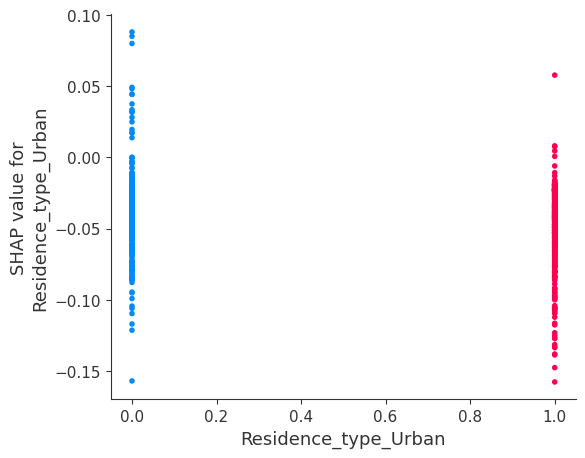

In [ ]:
shap.dependence_plot("Residence_type_Urban", shap_values[1], X_test,interaction_index="Residence_type_Urban")

Residence_type_urban = 1 contributes negatively the result of getting stroke

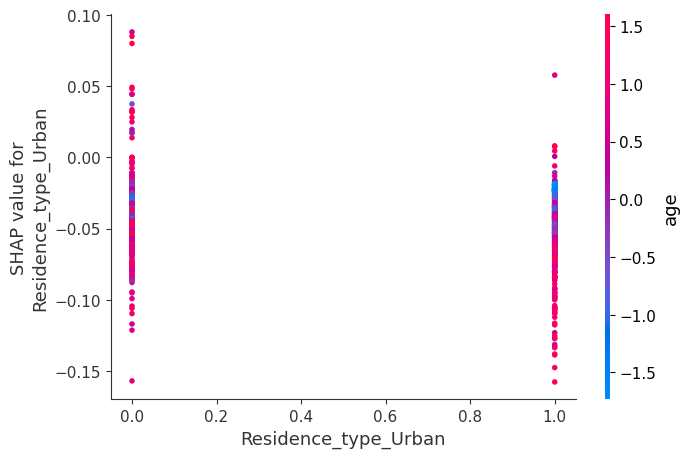

In [ ]:
shap.dependence_plot("Residence_type_Urban", shap_values[1], X_test)

This indicates that “residence_type_urban” interacts with “age” frequently.

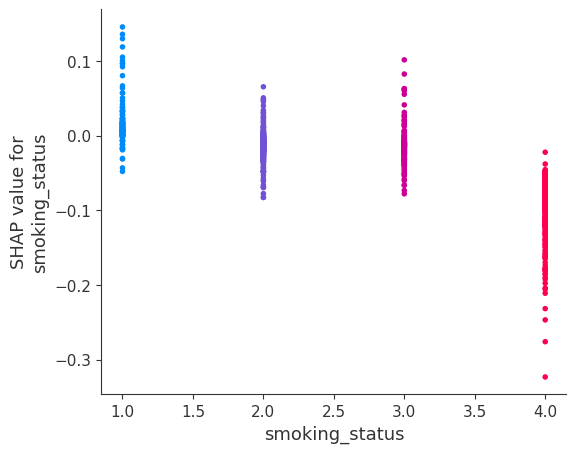

In [ ]:
shap.dependence_plot("smoking_status", shap_values[1], X_test,interaction_index="smoking_status")

Compared to individuals who have 'never smoked', 'formerly smoked', or have 'unknown' smoking status, active smoking most significantly increases the likelihood of experiencing a stroke.

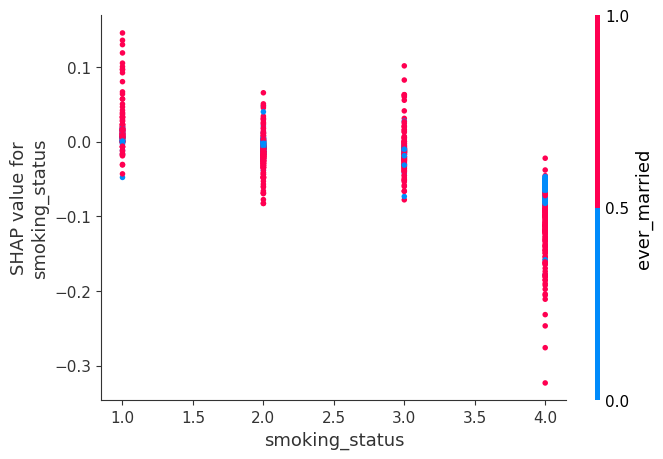

In [ ]:
shap.dependence_plot("smoking_status", shap_values[1], X_test)

This indicates that “smoking status” interacts with “ever_married” frequently.

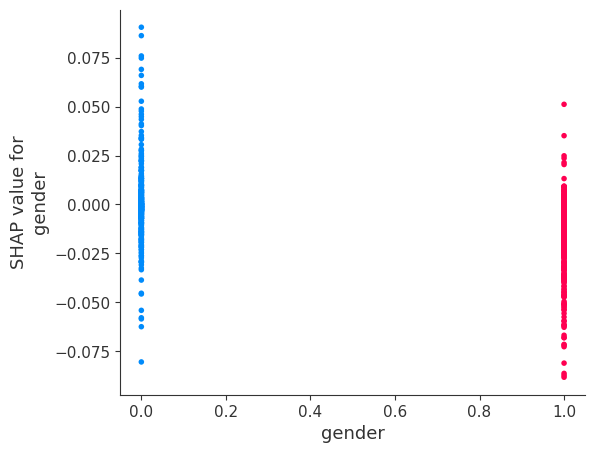

In [ ]:
shap.dependence_plot("gender", shap_values[1], X_test,interaction_index="gender")

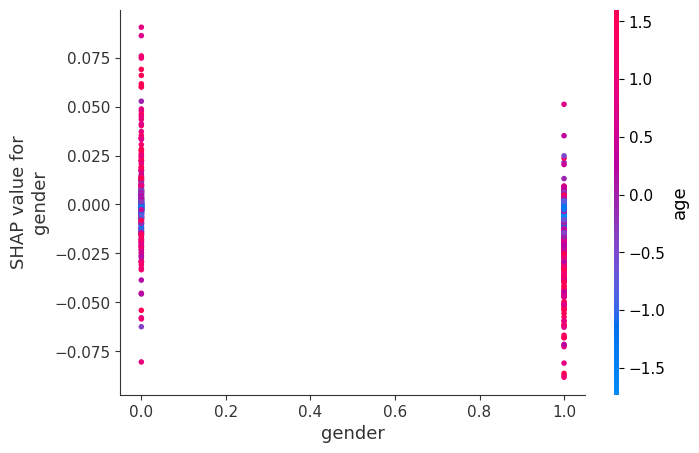

In [ ]:
shap.dependence_plot("gender", shap_values[1], X_test)

# **Force Plots for Local Interpretability**

We selected instances with positive labels and negative labels

In [ ]:
row_number = np.where(y_test[:,] == 1)[0]
positive_index_number = y_test.index[row_number]
positive_index_number

Index([220, 194,  52,  12, 248, 187,  75, 159, 153, 211, 139,  93,  18, 108,
        35, 192, 111, 224, 185, 128, 116,  31,  20,  17,  10, 130,  65,  85,
        42, 163, 228,  36, 182, 137],
      dtype='int64')

In [ ]:
choosen_instance = X_test.loc[[220]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Interpretation :¶ What you see above is a force plot visualizing shapley values for the features. Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

Model predicted 0.51, whereas the base_value is 0.4472. Thus, this person is predicted as having stroke. Two biggest effects are its age and the smoking status.

In [ ]:
choosen_instance = X_test.loc[[159]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Model predicted 0.97, whereas the base_value is 0.4472. Thus, this person is predicted as having a stroke. Two biggest effects are its age and the residence type.

In [ ]:
choosen_instance = X_test.loc[[20]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Model predicted 0.83, whereas the base_value is 0.4472. Thus, this person is predicted as having stroke. Two biggest effects are its age and the average glucose level

Interpretation :¶
What you see above is a force plot visualizing shapley values for the features. Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

Model predicted 0.07, whereas the base_value is 0.5401. Biggest effect is person having a smoking_status; This has decreased his chances of getting stroke.

In [ ]:
row_number = np.where(y_test[:,] == 0)[0]
negative_index_number = y_test.index[row_number]
negative_index_number

Index([1062, 4999,  976, 3886, 1875, 2790, 5028, 1677, 1311, 1261,
       ...
       3962,  823, 3489, 3606, 1600, 1230, 1515,  927,  992, 1855],
      dtype='int64', length=948)

In [ ]:
choosen_instance = X_test.loc[[1062]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Model predicted 0.15, whereas the base_value is 0.4472. Thus, this person is predicted as non-stroke. Two biggest effects that positively contribute to this result are the smoking status and the low value in average glucose level.

In [ ]:
choosen_instance = X_test.loc[[1261]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Model predicted 0.03, whereas the base_value is 0.4472. Thus, this person is predicted as non-stroke. Two biggest effects that positively contribute to  this result are low value in age and non self-employed work type.


In [ ]:
choosen_instance = X_test.loc[[3962]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Model predicted 0.19, whereas the base_value is 0.4472. Thus, this person is predicted as non-stroke. Two biggest effects that positively contribute to  this result are its urban residence type and non-private work type.